# Assignment 2 - Facial Recognition using one-shot learning

### Submmited by: Shay Sitri and Eden Luzon

## Imports

In [ ]:
import pandas as pd
import os
import shutil
from zipfile import ZipFile
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import read_image
import re
import seaborn as sns
from numpy import random
from PIL import Image
import numpy as np
import networkx as nx
from torchvision import transforms
from torch import nn
import time
import neptune
from neptune.types import File
from sklearn.metrics import classification_report
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import copy

/home/luzone/.conda/envs/edenenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Data Analysis

In [ ]:
# loading the temp.zip and creating a zip object
with ZipFile("/sise/home/luzone/deep learning/hw2/lfwa.zip", 'r') as zObject:

	# Extracting all the files of the zip
	# into a specific location.
	zObject.extractall(path = "/sise/home/luzone/deep learning/hw2/lfwa")

In [ ]:
newdir = '/sise/home/luzone/deep learning/hw2/full_lfwa'
# assign directory
directory = "/sise/home/luzone/deep learning/hw2/lfwa/lfwa/lfw2/lfw2"

os.mkdir(newdir)

df_statistic = {"name": [] , "count" : []}
# iterate over files in
# that directory
for path in os.listdir(directory):
    subdir = os.path.join(directory, path)
    name = path.replace("_" , " ")
    count = len(os.listdir(subdir))

    for file in os.listdir(subdir):
      filepath = os.path.join(subdir, file)
      newpath = os.path.join(newdir, file)
      os.rename(filepath,newpath)

    df_statistic["name"].append(name)
    df_statistic["count"].append(count)


In [ ]:
df_statistic = pd.DataFrame(df_statistic)
df_statistic = df_statistic.sort_values(by = ["count"], ascending = False)

In [ ]:
df_statistic

,name,count
1870,George W Bush,530
1047,Colin Powell,236
5458,Tony Blair,144
1404,Donald Rumsfeld,121
1891,Gerhard Schroeder,109
...,...,...
4100,Nina Jacobson,1
4101,Nina Pecari,1
4102,Nino DAngelo,1
5492,Trudi Lacey,1


In [ ]:
df_statistic.describe()

,count
count,5749.000000
mean,2.301792
std,9.016410
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,530.000000


In [ ]:
# assign directory
newdir = '/sise/home/luzone/deep learning/hw2/full_lfwa'

# creating pandas data frame of out data
df_persons = {"path": [] , "name" : []}

# iterate over files in
for path in os.listdir(newdir):
    name = path.replace("_", " ")
    file_path = os.path.join(newdir, path)
    df_persons["name"].append(name)
    df_persons["path"].append(file_path)


In [ ]:
class LfwaDataset(Dataset):
    """
        Attributes:
        img_labels (DataFrame): A Pandas DataFrame containing the paths and labels for the images.
        img_dir (str): The directory path where images are stored.
        transform (callable, optional): A function/transform that takes in an image and returns a transformed version.
            Useful for data augmentation.
        target_transform (callable, optional): A function/transform that takes in a label and returns a transformed version.
            Useful for label transformation.

        Parameters:
        annotations_file (DataFrame): The DataFrame containing image file names and their corresponding labels.
        img_dir (str): The directory where the images are stored.
        transform (callable, optional): Optional transform to be applied on a sample image.
        target_transform (callable, optional): Optional transform to be applied on a sample label.
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        if self.transform:
          image = self.transform(image)
        if self.target_transform:
          label = self.target_transform(label)
        return image, label

In [ ]:
df_persons = pd.DataFrame(df_persons)
df_persons

,path,name
0,/sise/home/luzone/deep learning/hw2/full_lfwa/...,Aaron Eckhart 0001.jpg
1,/sise/home/luzone/deep learning/hw2/full_lfwa/...,Aaron Guiel 0001.jpg
2,/sise/home/luzone/deep learning/hw2/full_lfwa/...,Aaron Patterson 0001.jpg
3,/sise/home/luzone/deep learning/hw2/full_lfwa/...,Aaron Peirsol 0001.jpg
4,/sise/home/luzone/deep learning/hw2/full_lfwa/...,Aaron Peirsol 0002.jpg
...,...,...
13228,/sise/home/luzone/deep learning/hw2/full_lfwa/...,Zorica Radovic 0001.jpg
13229,/sise/home/luzone/deep learning/hw2/full_lfwa/...,Zulfiqar Ahmed 0001.jpg
13230,/sise/home/luzone/deep learning/hw2/full_lfwa/...,Zumrati Juma 0001.jpg
13231,/sise/home/luzone/deep learning/hw2/full_lfwa/...,Zurab Tsereteli 0001.jpg


In [ ]:
full_dataset = LfwaDataset(df_persons,newdir)

# Create train & test & validation

In [ ]:
def create_train_test_pd(path):

  """
    Reads a text file from a specified path and converts it into a pandas DataFrame.
    The file should contain pairs of images, each pair either being similar or not.

    Parameters:
    - path (str): The file path of the text file to be read.

    Returns:
    - df (pd.DataFrame): A DataFrame containing the following columns:
      - 'name1': The name associated with the first image.
      - 'img1': The index for the first image.
      - 'name2': The name associated with the second image (could be the same as name1 for similar pairs).
      - 'img2': The index for the second image.
      - 'sim': An indicator of similarity (1 for similar, 0 for not similar).

    Example of row in the file:
    sim - Aaron_Peirsol	1	2
    diff - AJ_Cook	1	Marsha_Thomason	1

   """
  file = open(path, "r")
  content = file.read().split("\n")[1:]

  pd_dict = {"path1" : [] , "path2" :[] , "sim" : [] , "name1" : [] , "name2" : []}
  for pair in content:
    pair_split = pair.split("\t")
    if len(pair_split) == 3:
      path1_name = pair_split[0] + "_" + pair_split[1].rjust(4, '0') + ".jpg"
      path2_name = pair_split[0] + "_" + pair_split[2].rjust(4, '0') + ".jpg"
      pd_dict["path1"].append(path1_name)
      pd_dict["path2"].append(path2_name)
      pd_dict["sim"].append(1)
      pd_dict["name1"].append(pair_split[0])
      pd_dict["name2"].append(pair_split[0])
    elif len(pair_split) == 4:
      path1_name = pair_split[0] + "_" + pair_split[1].rjust(4, '0') + ".jpg"
      path2_name = pair_split[2] + "_" + pair_split[3].rjust(4, '0') + ".jpg"
      pd_dict["path1"].append(path1_name)
      pd_dict["path2"].append(path2_name)
      pd_dict["sim"].append(0)
      pd_dict["name1"].append(pair_split[0])
      pd_dict["name2"].append(pair_split[2])

  df = pd.DataFrame.from_dict(pd_dict)

  return df


In [ ]:
# create train df
train_path = "/sise/home/luzone/deep learning/hw2/pairsDevTrain.txt"
train_df = create_train_test_pd(train_path)

In [ ]:
train_df

,path1,path2,sim,name1,name2
0,Aaron_Peirsol_0001.jpg,Aaron_Peirsol_0002.jpg,1,Aaron_Peirsol,Aaron_Peirsol
1,Aaron_Peirsol_0003.jpg,Aaron_Peirsol_0004.jpg,1,Aaron_Peirsol,Aaron_Peirsol
2,Aaron_Sorkin_0001.jpg,Aaron_Sorkin_0002.jpg,1,Aaron_Sorkin,Aaron_Sorkin
3,Abdel_Nasser_Assidi_0001.jpg,Abdel_Nasser_Assidi_0002.jpg,1,Abdel_Nasser_Assidi,Abdel_Nasser_Assidi
4,Abdullah_0001.jpg,Abdullah_0003.jpg,1,Abdullah,Abdullah
...,...,...,...,...,...
2195,Tom_Vilsack_0001.jpg,Wayne_Ferreira_0005.jpg,0,Tom_Vilsack,Wayne_Ferreira
2196,Trisha_Meili_0001.jpg,Vladimiro_Montesinos_0003.jpg,0,Trisha_Meili,Vladimiro_Montesinos
2197,Ty_Votaw_0001.jpg,Wayne_Allard_0001.jpg,0,Ty_Votaw,Wayne_Allard
2198,Vytas_Danelius_0001.jpg,Zaini_Abdullah_0001.jpg,0,Vytas_Danelius,Zaini_Abdullah


We can see that our data is balanced: same amount of similar and different pairs.

In [ ]:
train_df.loc[train_df['sim']==1].count()

path1    1100
path2    1100
sim      1100
name1    1100
name2    1100
dtype: int64

In [ ]:
# create test df
test_path = "/sise/home/luzone/deep learning/hw2/pairsDevTest.txt"
test_df = create_train_test_pd(test_path)

In [ ]:
test_df

,path1,path2,sim,name1,name2
0,Abdullah_Gul_0013.jpg,Abdullah_Gul_0014.jpg,1,Abdullah_Gul,Abdullah_Gul
1,Abdullah_Gul_0013.jpg,Abdullah_Gul_0016.jpg,1,Abdullah_Gul,Abdullah_Gul
2,Abdullatif_Sener_0001.jpg,Abdullatif_Sener_0002.jpg,1,Abdullatif_Sener,Abdullatif_Sener
3,Adel_Al-Jubeir_0001.jpg,Adel_Al-Jubeir_0003.jpg,1,Adel_Al-Jubeir,Adel_Al-Jubeir
4,Al_Pacino_0001.jpg,Al_Pacino_0002.jpg,1,Al_Pacino,Al_Pacino
...,...,...,...,...,...
995,Susan_Whelan_0001.jpg,Wolfgang_Schneiderhan_0001.jpg,0,Susan_Whelan,Wolfgang_Schneiderhan
996,Takeo_Fukui_0001.jpg,Will_Ofenheusle_0001.jpg,0,Takeo_Fukui,Will_Ofenheusle
997,Tamara_Mowry_0001.jpg,Zach_Parise_0001.jpg,0,Tamara_Mowry,Zach_Parise
998,Tatiana_Kennedy_Schlossberg_0001.jpg,Thomas_Watjen_0001.jpg,0,Tatiana_Kennedy_Schlossberg,Thomas_Watjen


In [ ]:
test_df.loc[test_df['sim']==1].count()

path1    500
path2    500
sim      500
name1    500
name2    500
dtype: int64

## Examples of the samples in our data

In [ ]:
def print_image_per_person(df, path, name):
  num_img_per_person = df.loc[df["name"] == name]["count"].values[0]
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,3))
  for i in range(5):
    random_img = str(random.randint(1 , num_img_per_person))
    string_img = path+"/" + name.replace(" " , "_") + "_" + random_img.rjust(4, '0') + ".jpg"
    image = Image.open(string_img)
    axs[i].axis("off")
    axs[i].imshow(image, cmap="gray")
    fig.suptitle(f"Example: 5 Images of {name}" , fontsize = 16)
  plt.tight_layout()
  plt.show()

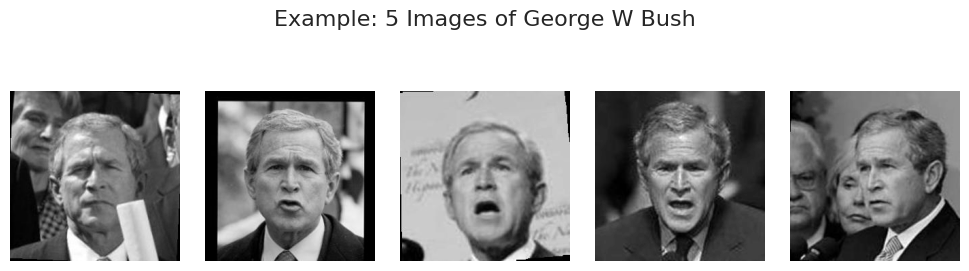

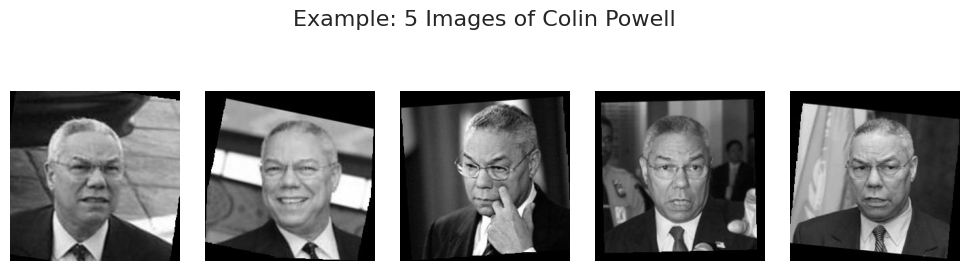

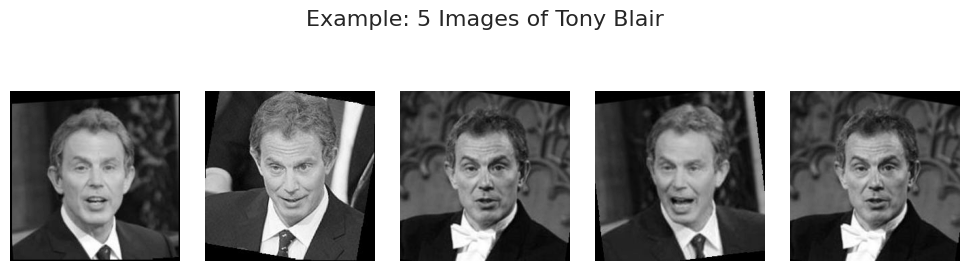

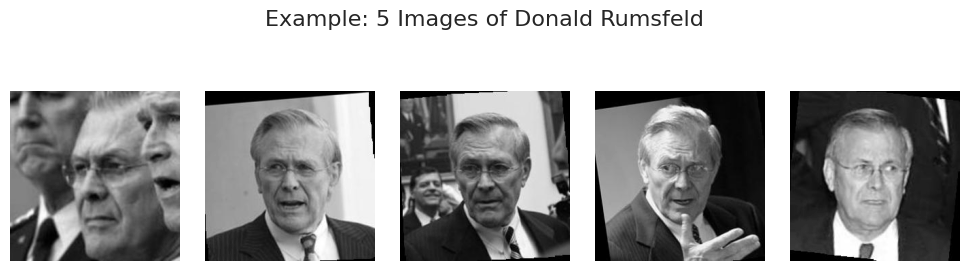

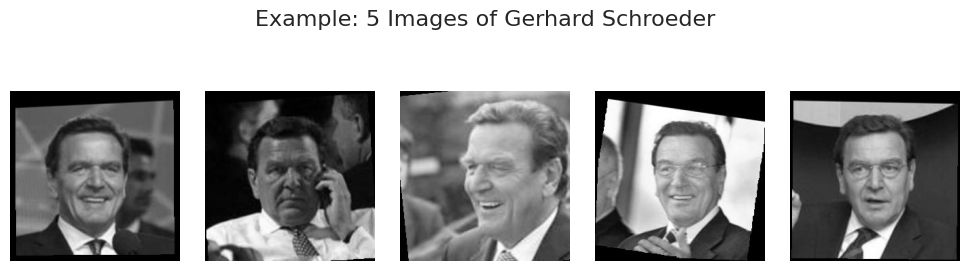

In [ ]:
top_5_persons = df_statistic.head(5)["name"].values
for name in top_5_persons:
  print_image_per_person(df_statistic ,newdir, name)


## Pairs dataset

In [ ]:
class LfwaDatasetPairs(Dataset):
    """
        Attributes:
            img_labels (DataFrame): A Pandas DataFrame containing the paths for image pairs and their corresponding labels.
            img_dir (str): The directory path where images are stored.
            transform (callable, optional): A function/transform that takes in an image and returns a transformed version.
                This is applied to each image individually.
            target_transform (callable, optional): A function/transform that takes in a label and returns a transformed version.
                This is useful for modifying labels if necessary.

        Parameters:
            annotations_file (DataFrame): The DataFrame containing pairs of image file names and their corresponding labels.
            img_dir (str): The directory where the images are stored.
            transform (callable, optional): Optional transform to be applied on each image.
            target_transform (callable, optional): Optional transform to be applied on the label.
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path1 = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_path2 = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image1 = read_image(img_path1)
        image2 = read_image(img_path2)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
          image1 = self.transform(image1)
          image2 = self.transform(image2)
        if self.target_transform:
          label = self.target_transform(label)
        return image1, image2, label , img_path1 ,img_path2

we have 2200 pairs of train. We want to split it teain-validation : 80:20 therefor we need 440 unique pairs such that none of the persons apears in train dataset.

In [ ]:
train_df_grouped = train_df.groupby(by=["name1", "name2"]).size().reset_index(name='count')
merged_df = pd.merge(train_df, train_df_grouped, on=["name1", "name2"], how="left")

In [ ]:
merged_df = merged_df.drop_duplicates(subset = ["name1" ,"name2"])[["name1" ,"name2" ,"count"]]

In [ ]:
merged_df

,name1,name2,count
0,Aaron_Peirsol,Aaron_Peirsol,2
2,Aaron_Sorkin,Aaron_Sorkin,1
3,Abdel_Nasser_Assidi,Abdel_Nasser_Assidi,1
4,Abdullah,Abdullah,2
6,Abdullah_al-Attiyah,Abdullah_al-Attiyah,2
...,...,...,...
2195,Tom_Vilsack,Wayne_Ferreira,1
2196,Trisha_Meili,Vladimiro_Montesinos,1
2197,Ty_Votaw,Wayne_Allard,1
2198,Vytas_Danelius,Zaini_Abdullah,1


In [ ]:
g = nx.from_pandas_edgelist(merged_df, 'name1', 'name2', ['count'])

In [ ]:
complete_subgraph = list(nx.connected_components(g))

In [ ]:
connected_components = []
connected_components_weight = 0
for subgraph_nodes in complete_subgraph:
    subgraph = g.subgraph(subgraph_nodes)
    total_weight = sum(subgraph[u][v]['count'] for u, v in subgraph.edges())
    if connected_components_weight <= 440:
        if nx.is_connected(g.subgraph(subgraph_nodes)):
          connected_components.append(subgraph.nodes())
          connected_components_weight += total_weight
    else:
      break

In [ ]:
validation_set = pd.DataFrame()
for node in connected_components:
  for person in list(node.keys()):
    person_images_paths = train_df.loc[(train_df['name1'] == person) | (train_df['name2'] == person)]
    validation_set = pd.concat([validation_set, person_images_paths])
    # images_paths2 = train_df.loc[train_df['name2'] == person]
    # print(images_paths1, images_paths2)

validation_df = validation_set.drop_duplicates(subset=['path1', 'path2'])

In [ ]:
validation_df

,path1,path2,sim,name1,name2
0,Aaron_Peirsol_0001.jpg,Aaron_Peirsol_0002.jpg,1,Aaron_Peirsol,Aaron_Peirsol
1,Aaron_Peirsol_0003.jpg,Aaron_Peirsol_0004.jpg,1,Aaron_Peirsol,Aaron_Peirsol
2,Aaron_Sorkin_0001.jpg,Aaron_Sorkin_0002.jpg,1,Aaron_Sorkin,Aaron_Sorkin
1101,Aaron_Sorkin_0002.jpg,Frank_Solich_0005.jpg,0,Aaron_Sorkin,Frank_Solich
356,Frank_Solich_0001.jpg,Frank_Solich_0002.jpg,1,Frank_Solich,Frank_Solich
...,...,...,...,...,...
1464,Coretta_Scott_King_0001.jpg,Tom_Welch_0001.jpg,0,Coretta_Scott_King,Tom_Welch
235,Corinne_Coman_0001.jpg,Corinne_Coman_0002.jpg,1,Corinne_Coman,Corinne_Coman
1465,Costas_Simitis_0001.jpg,Richard_Perle_0001.jpg,0,Costas_Simitis,Richard_Perle
236,Costas_Simitis_0001.jpg,Costas_Simitis_0003.jpg,1,Costas_Simitis,Costas_Simitis


In [ ]:
validation_names = list(set(list(np.concatenate((validation_df['name1'].values, validation_df['name2'].values), axis=0))))

In [ ]:
train_df = train_df.loc[(~train_df['name1'].isin(validation_names)) |(~train_df['name2'].isin(validation_names))]

In [ ]:
train_df

,path1,path2,sim,name1,name2
238,Cristina_Saralegui_0001.jpg,Cristina_Saralegui_0002.jpg,1,Cristina_Saralegui,Cristina_Saralegui
239,Cruz_Bustamante_0001.jpg,Cruz_Bustamante_0004.jpg,1,Cruz_Bustamante,Cruz_Bustamante
240,Dalai_Lama_0001.jpg,Dalai_Lama_0002.jpg,1,Dalai_Lama,Dalai_Lama
241,Dale_Earnhardt_Jr_0001.jpg,Dale_Earnhardt_Jr_0002.jpg,1,Dale_Earnhardt_Jr,Dale_Earnhardt_Jr
242,Dale_Earnhardt_Jr_0001.jpg,Dale_Earnhardt_Jr_0003.jpg,1,Dale_Earnhardt_Jr,Dale_Earnhardt_Jr
...,...,...,...,...,...
2195,Tom_Vilsack_0001.jpg,Wayne_Ferreira_0005.jpg,0,Tom_Vilsack,Wayne_Ferreira
2196,Trisha_Meili_0001.jpg,Vladimiro_Montesinos_0003.jpg,0,Trisha_Meili,Vladimiro_Montesinos
2197,Ty_Votaw_0001.jpg,Wayne_Allard_0001.jpg,0,Ty_Votaw,Wayne_Allard
2198,Vytas_Danelius_0001.jpg,Zaini_Abdullah_0001.jpg,0,Vytas_Danelius,Zaini_Abdullah


In [ ]:
train_names = list(set(list(np.concatenate((train_df['name1'].values, train_df['name2'].values), axis=0))))

In [ ]:
print(set(train_names).intersection(set(validation_names)))

set()


In [ ]:
normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((105, 105))
])

# create train dataset
trainDataset = LfwaDatasetPairs(train_df, newdir , transform = normalize)

# create validation dataset
valDataset = LfwaDatasetPairs(validation_df, newdir , transform = normalize)

# create test dataset
testDataset = LfwaDatasetPairs(test_df, newdir , transform = normalize)

In [ ]:
len(trainDataset)

1757

In [ ]:
len(valDataset)

443

In [ ]:
len(testDataset)

1000

## Print Pairs

In [ ]:
labels_map = {0: "Different", 1: "Similar"}

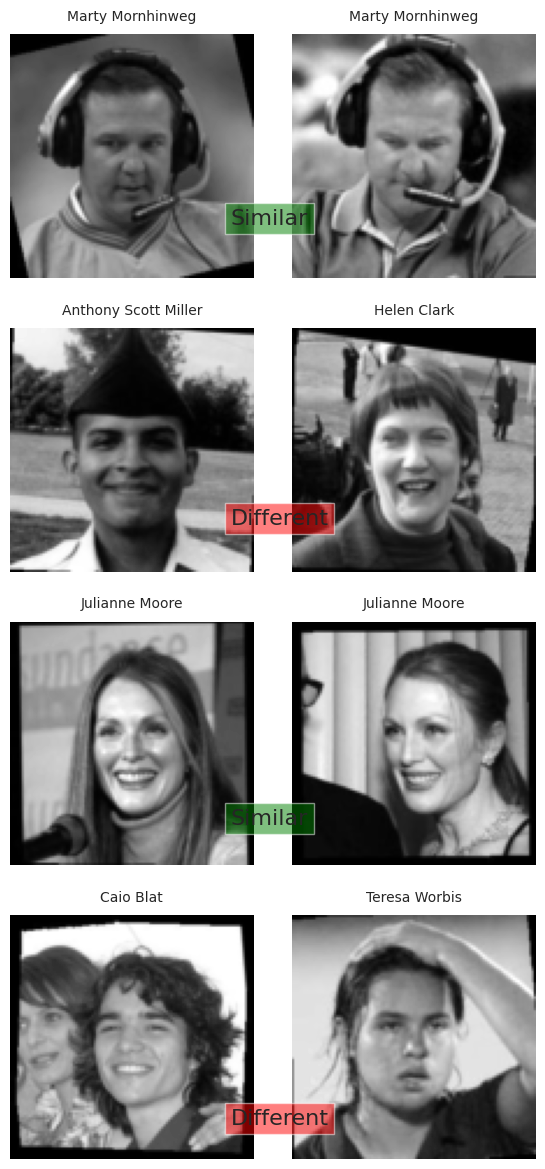

In [ ]:
# Create the figure and axes
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(6, 12))


for i in range(4):
    sample_idx = torch.randint(len(trainDataset), size=(1,)).item()
    img1, img2, label, path1, path2 = trainDataset[sample_idx]

    pattern = r'_(?=\d+)'
    name1 = re.split(pattern, path1.split('/')[7], 1)[0].replace("_"," " )
    name2 = re.split(pattern, path2.split('/')[7], 1)[0].replace("_"," " )

    # Set titles for each image
    axs[i, 0].set_title(name1, fontsize=10, pad=10)  # Title above the first image of the row
    axs[i, 1].set_title(name2, fontsize=10, pad=10)  # Title above the second image of the row

    # Display the images
    axs[i, 0].axis("off")
    axs[i, 0].imshow(img1.squeeze(), cmap="gray")

    axs[i, 1].axis("off")
    axs[i, 1].imshow(img2.squeeze(), cmap="gray")

    row_title = labels_map[label]
    color = 'green' if label == 1 else 'red'
    fig.text(0.43, 0.8- i * 0.25   ,
            row_title,
            fontsize=16,
            bbox=dict(facecolor=color, alpha=0.5))

plt.tight_layout()
plt.show()


## Create Dataloader

In [ ]:
train_data_loader = torch.utils.data.DataLoader(trainDataset,batch_size=128,shuffle=True, num_workers=6)

In [ ]:
val_data_loader = torch.utils.data.DataLoader(valDataset,batch_size=128,shuffle=True, num_workers=6)

In [ ]:
test_data_loader = torch.utils.data.DataLoader(testDataset,batch_size=128,shuffle=True, num_workers=6)

## Siamese Neural Networks

In [ ]:
# this method can be defined outside your model class
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)
        torch.nn.init.normal_(m.bias, mean=0.5, std=0.01)

In [ ]:
class SiameseNetworks(nn.Module):
    """
        Attributes:
            sigmoid (nn.Module): Sigmoid activation function for ensuring outputs are in the (0,1) range, indicating similarity.
            embedding_network (nn.Sequential): The convolutional network used to learn embeddings of the input images.
            final_height (int): The height of the output feature map from the convolutional layers.
            final_weight (int): The width of the output feature map from the convolutional layers.
            fc1 (nn.Linear): First fully connected layer to reduce the dimensionality from the feature map to 4096 features.
            fc2 (nn.Linear): Second fully connected layer that outputs a single value representing the similarity score.

        Parameters:
            height (int): The height of the input images.
            weight (int): The width of the input images.
            filters (list): A list of integers specifying the kernel sizes and pool sizes for the convolutional and pooling layers.
    """
    def __init__(self, height, weight, filters):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

        self.embedding_network = nn.Sequential(
              nn.Conv2d(1, 64 , kernel_size=filters[0]),
              nn.ReLU(),
              nn.MaxPool2d(filters[1],filters[1]),
              nn.Dropout(),
              nn.Conv2d(64, 128 , kernel_size=filters[2]),
              nn.ReLU(),
              nn.MaxPool2d(filters[3],filters[3]),
              nn.Conv2d(128, 128 , kernel_size= filters[4]),
              nn.ReLU(),
              nn.MaxPool2d(filters[5],filters[5]),
              nn.Conv2d(128, 256 , kernel_size= filters[6]),
              nn.ReLU()

        )


        self.final_height = ((((((((height - filters[0] + 1) // filters[1]) - filters[2] + 1) // filters[3]) - filters[4] + 1) // filters[5]) - filters[6] + 1))
        self.final_weight = ((((((((height - filters[0] + 1) // filters[1]) - filters[2] + 1) // filters[3]) - filters[4] + 1) // filters[5]) - filters[6] + 1))
        self.fc1 = nn.Linear(self.final_height * self.final_weight * 256 , 4096)
        self.fc2 = nn.Linear(4096, 1)

    def forward_once(self,x):
        """
        Processes an input image through the embedding network and the first fully connected layer.

        Parameters:
            x (Tensor): A batch of input images.

        Returns:
            Tensor: The processed features after the embedding network and the first fully connected layer.
        """
        x = self.embedding_network(x)
        x = x.view(-1,self.final_height * self.final_weight * 256)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x


    def forward(self, img1 , img2):
        """
        Processes pairs of images through the network, computes their embeddings, and measures the absolute difference
        to assess similarity.

        Parameters:
        img1 (Tensor): The first image in the pair.
        img2 (Tensor): The second image in the pair.

        Returns:
        Tensor: A single value representing the similarity score between the two images.
        """
        output1 = self.forward_once(img1)
        output2 = self.forward_once(img2)
        distance = torch.abs(output1 - output2)
        distance = self.fc2(distance)
        distance =  self.sigmoid(distance)
        return distance

## Train

In [ ]:
def train(model, threshold, train_loader, validation_loader, optimizer, epochs, model_path, initial_momentum, momentum_increase, max_momentum, run , scheduler, aug = None):
    """
    Trains a Siamese neural network model.

    Parameters:
        model (nn.Module): The neural network model to be trained.
        threshold (float): The threshold for converting model outputs to binary labels.
        train_loader (DataLoader): DataLoader for training data.
        validation_loader (DataLoader): DataLoader for validation data.
        optimizer (Optimizer): The optimizer used for training.
        epochs (int): The number of epochs to train the model.
        model_path (str): Path where the trained model should be saved.
        initial_momentum (float): Initial value for the momentum parameter in the optimizer.
        momentum_increase (float): Increment value for the momentum per epoch until it reaches max_momentum.
        max_momentum (float): Maximum value for the momentum parameter in the optimizer.
        run (dict): A dictionary for logging training and validation metrics.
        scheduler (lr_scheduler): Learning rate scheduler.

    Returns:
        tuple: A tuple containing the best model based on validation loss and the count of epochs run.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.BCELoss()
    train_preds, train_labels, train_sim_scores, train_pairs1, train_pairs2, train_name1, train_name2 = [], [], [], [], [], [], []
    val_preds, val_labels, val_sim_scores, val_pairs1, val_pairs2, val_name1, val_name2 = [], [], [], [], [], [], []
    best_val_loss = 1000000000000000000
    counter = 0
    count_epoch = 0
    best_model = model
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        running_loss, correct, total = 0.0, 0, 0
        vloss, vcorrect, vtotal = 0.0, 0, 0
        last_epoch = (epoch == epochs - 1)

        current_lr = optimizer.param_groups[0]['lr']
        for i, data in enumerate(train_loader, 0):
            img1, img2, y, name1, name2 = data
            if aug:
                img1 = apply_augmentation(img1)
                img2 = apply_augmentation(img2)
            img1, img2, y = img1.to(device), img2.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(img1, img2).squeeze()

            count_epoch = epoch
            # Use binary cross-entropy loss with logits
            loss = criterion(outputs, y.float())

            loss.backward()
            optimizer.step()

            # Increase momentum
            current_momentum = initial_momentum + epoch * momentum_increase
            if current_momentum < max_momentum:
              for param_group in optimizer.param_groups:
                  param_group['momentum'] = current_momentum

            running_loss += loss.item()
            preds = (outputs >= threshold).float()
            correct_batch = (preds == y).sum().item()
            correct += correct_batch
            total += y.size(0)

            scheduler.step()

            run["train/loss"].append(loss.item())
            run["train/acc"].append(correct_batch / y.size(0))

        if last_epoch  or counter == 20:
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(y.cpu().numpy())
            train_sim_scores.extend(outputs.detach().cpu().numpy())
            train_pairs1.extend(img1.cpu().numpy())
            train_pairs2.extend(img2.cpu().numpy())
            train_name1.extend(list(name1))
            train_name2.extend(list(name2))

            log_info_to_neptune(train_preds, train_labels, train_sim_scores, train_name1, train_name2, train_pairs1, train_pairs2, 'train', run)
            return best_model , count_epoch

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        epoch_duration = time.time() - start_time
        vepoch_acc, vepoch_loss, val_time, conf_matrix = test(model, threshold, validation_loader, run, 'val')

        if vepoch_loss > best_val_loss:
            counter += 1
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(), model_path)
        else:
            best_val_loss = vepoch_loss
            counter = 0



        print(f'Epoch {epoch + 1} | Train Accuracy: {epoch_acc:.4f}| Train loss: {epoch_loss:.4f} | Duration: {epoch_duration:.2f} sec')

    total_training_time = time.time() - start_time
    print(f'Total training time: {int(total_training_time):02} (sec)')

    return best_model , count_epoch


## Test

In [ ]:
def test(model, threshold, loader, run, name):
    """
    Evaluates a trained Siamese neural network model using a provided data loader and logs the evaluation results.

    Parameters:
        model (nn.Module): The trained neural network model to be evaluated.
        threshold (float): Threshold value to convert model outputs to binary predictions.
        loader (DataLoader): DataLoader containing the dataset to be evaluated.
        run (dict): Dictionary used for logging the metrics and results during the evaluation.
        name (str): A descriptive name for the evaluation phase (e.g., 'test', 'validation') to tag the logs.

    Returns:
        tuple: Returns a tuple containing the calculated accuracy, average loss, testing time, and confusion matrix
               of the evaluation phase.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    start_time = time.time()
    criterion = nn.BCELoss()
    test_preds, test_labels, test_sim_scores, test_pairs1, test_pairs2, test_name1, test_name2 = [], [], [], [], [], [], []
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
          correct_batch = 0
          img1, img2, y, name1, name2 = data
          img1, img2, y = img1.to(device), img2.to(device), y.to(device)
          outputs = model(img1, img2).squeeze()

          loss = criterion(outputs, y.float())
          total_loss += loss.item()
          run[f"{name}/loss"].append(loss.item())

          preds = (outputs >= threshold).float()
          correct_batch = (preds == y).sum().item()
          correct += correct_batch
          total += y.size(0)

          run[f"{name}/acc"].append(correct_batch / y.size(0))

          test_preds.extend(preds.cpu().numpy())
          test_labels.extend(y.cpu().numpy())
          test_sim_scores.extend(outputs.detach().cpu().numpy())
          test_pairs1.extend(img1.cpu().numpy())
          test_pairs2.extend(img2.cpu().numpy())
          test_name1.extend(list(name1))
          test_name2.extend(list(name2))

    log_info_to_neptune(test_preds, test_labels, test_sim_scores, test_name1, test_name2, test_pairs1, test_pairs2, name, run)

    conf_matrix = confusion_matrix(test_labels, test_preds)
    print(conf_matrix)
    accuracy = correct / total
    avg_loss = total_loss / len(loader)
    test_time = time.time() - start_time
    print(f'Total {name} time: {int(test_time):02} (sec)')
    print(f'{name} Accuracy: {accuracy:.4f} | {name} loss: {avg_loss:.4f}')

    df_cm = pd.DataFrame(conf_matrix, index=["P", "N"], columns=["T", "F"])
    run[f'{name}/confusion_matrix_table'].upload(neptune.types.File.as_html(df_cm))
    return accuracy, avg_loss, test_time, conf_matrix

In [ ]:
def log_info_to_neptune(preds, labels, sim_scores, name1, name2, pairs1, pairs2, folder, run):
    """
    Logs detailed model predictions and performance metrics to Neptune.

    Parameters:
        preds (list): A list of model predictions, usually binary after applying a threshold.
        labels (list): The ground truth labels corresponding to the predictions.
        sim_scores (list): The raw similarity scores from the model before thresholding.
        name1 (list): Names or identifiers for the first item in each compared pair.
        name2 (list): Names or identifiers for the second item in each compared pair.
        pairs1 (list): First items of the pairs, typically images or representations.
        pairs2 (list): Second items of the pairs, typically images or representations.
        folder (str): The folder or tag under which to log the reports in Neptune.
        run (neptune.run): The active Neptune run instance to which the data should be logged.
    """
    cv = pd.DataFrame({"pred": preds, "label": labels, "sim_score": sim_scores, "name1":name1, "name2":name2})
    print(f"len labels: {len(labels)}")
    index_list = list(range(len(pairs1)))
    run[f"{folder}/prediction_report"].upload(File.as_html(cv))
    run[f"{folder}/metrics_report"] = classification_report(labels, preds)

In [ ]:
def run_experiment(exp_dict, train_loader, val_loader, test_loader , aug = None):
    """
    Runs experiments for a Siamese network model with varying configurations and evaluates the performance across different thresholds.

    Parameters:
        exp_dict (dict): A dictionary containing configurations for different experiments.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        test_loader (DataLoader): DataLoader for the testing dataset.
        aug (callable, optional): An augmentation function applied to the input data.

    Returns:
        dict: A dictionary containing the AUC or confusion matrices for each experiment across different thresholds.

    Each experiment in exp_dict can contain the following configurations:
        - optimizer_name: The name of the optimizer to use ('SGD' or 'AdamW').
        - image_size: The size of the input images.
        - L2_rate: The L2 regularization rate.
        - filter_size: List of filter sizes for the convolutional layers.
        - epochs: Number of training epochs.
        - init_learning_rate: Initial learning rate for the optimizer.
        - init_momentum: Initial momentum for optimizers that support it.
    """
    MAX_MOMENTUM = 1
    for exp in exp_dict:
        auc_dict = {}
        optimizer_name = exp_dict[exp]["optimizer_name"]
        image_size = exp_dict[exp]["image size"]
        L2 = exp_dict[exp]["L2_rate"]
        filters = exp_dict[exp]["filter_size"]
        epoch = exp_dict[exp]["epochs"]
        init_learning_rate = exp_dict[exp]["init_learning_rate"]
        init_momentum = exp_dict[exp]["init_momentum"]
        epoch_list = list(range(epoch))
        MODEL_PATH = f"/sise/home/luzone/deep learning/hw2/model{exp}.pth"
        auc_dict[exp] = []

        for threshold in np.arange(0, 1.1, 0.1): # i is the treshold
          run = neptune.init_run(
              project="shay.sitri/Siamese",
              api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkZDRkNmUzOC0wZDAxLTQ5NjktYjE5OS1mYzcyZjZjNzhjNzgifQ==",
          )  # your credentials
          params = {"exp_number": exp ,"init_learning_rate": init_learning_rate, "optimizer": optimizer_name, "init_momentum": init_momentum,"Threshold": threshold, "epochs" : epoch, "image size" : image_size, "filters" : filters , "L2" :L2}
          run["parameters"] = params

          model = SiameseNetworks(image_size, image_size, filters).to(device)
          model.apply(weights_init)

          if optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=init_learning_rate, momentum=init_momentum, weight_decay = L2)
          else:
            optimizer = optim.AdamW(model.parameters(), lr= init_learning_rate, weight_decay = L2)
          scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


          model , last_epoch = train(model,threshold, train_loader, val_loader, optimizer, epoch, MODEL_PATH, init_momentum, init_learning_rate, MAX_MOMENTUM, run, scheduler,aug)
          test_acc, test_loss, test_time, confusion_matrix = test(model, threshold, test_loader, run, 'test')
          auc_dict[exp].append(confusion_matrix)
          run["last_epoch"] = last_epoch
          run.stop()
    return auc_dict

## Experiments:

### Experiment 1

In [ ]:
## EXPERIMENTS
experiment_dict = {
    1: {"image size": 105, "init_learning_rate": 0.1, "init_momentum": 0.5 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    2: {"image size": 105, "init_learning_rate": 0.01, "init_momentum": 0.5 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    3: {"image size": 105, "init_learning_rate": 0.001, "init_momentum": 0.5 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    4: {"image size": 105, "init_learning_rate": 0.1, "init_momentum": 0.9 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    5: {"image size": 105, "init_learning_rate": 0.01, "init_momentum": 0.9 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    6: {"image size": 105, "init_learning_rate": 0.001, "init_momentum": 0.9 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    7: {"image size": 105, "init_learning_rate": 0.1, "init_momentum": 0.5 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    8: {"image size": 105, "init_learning_rate": 0.01, "init_momentum": 0.5 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    9: {"image size": 105, "init_learning_rate": 0.001, "init_momentum": 0.5 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    10: {"image size": 105, "init_learning_rate": 0.1, "init_momentum": 0.9 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    11: {"image size": 105, "init_learning_rate": 0.01, "init_momentum": 0.9 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    12: {"image size": 105, "init_learning_rate": 0.001, "init_momentum": 0.9 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
}

auc_dict = run_experiment(experiment_dict, train_data_loader, val_data_loader, test_data_loader)

### Experiment 2:

In [ ]:
experiment_dict1 = {
    1: {"image size": 105, "init_learning_rate": 0.1, "init_momentum": 0.5 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
    2: {"image size": 105, "init_learning_rate": 0.01, "init_momentum": 0.5 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
    3: {"image size": 105, "init_learning_rate": 0.001, "init_momentum": 0.5 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
    4: {"image size": 105, "init_learning_rate": 0.1, "init_momentum": 0.9 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
    5: {"image size": 105, "init_learning_rate": 0.01, "init_momentum": 0.9 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
    6: {"image size": 105, "init_learning_rate": 0.001, "init_momentum": 0.9 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
    7: {"image size": 105, "init_learning_rate": 0.1, "init_momentum": 0.5 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
    8: {"image size": 105, "init_learning_rate": 0.01, "init_momentum": 0.5 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
    9: {"image size": 105, "init_learning_rate": 0.001, "init_momentum": 0.5 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
    10: {"image size": 105, "init_learning_rate": 0.1, "init_momentum": 0.9 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
    11: {"image size": 105, "init_learning_rate": 0.01, "init_momentum": 0.9 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
    12: {"image size": 105, "init_learning_rate": 0.001, "init_momentum": 0.9 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
}

auc_dict = run_experiment(experiment_dict1, train_data_loader, val_data_loader, test_data_loader)

### Experiment 3:

In [ ]:
## EXPERIMENTS
experiment_dict2 = {
    1: {"image size": 250, "init_learning_rate": 0.1, "init_momentum": 0.5 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    2: {"image size": 250, "init_learning_rate": 0.1, "init_momentum": 0.9 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    3: {"image size": 250, "init_learning_rate": 0.001, "init_momentum": 0.9 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
    4: {"image size": 250, "init_learning_rate": 0.001, "init_momentum": 0.9 , "L2_rate": 0.1, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
}

auc_dict2 = run_experiment(experiment_dict2, train_data_loader, val_data_loader, test_data_loader)

### Experiment 4:

In [ ]:
augmantation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

def apply_augmentation(batch):
    return torch.stack([augmantation(img) for img in batch])

In [ ]:
## EXPERIMENTS
experiment_dict5= {
    1: {"image size": 105, "init_learning_rate": 0.1, "init_momentum": 0.5 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "SGD", "epochs" : 200},
    2: {"image size": 105, "init_learning_rate": 0.001, "init_momentum": 0.9 , "L2_rate": 0, "filter_size" : [10,2,7,2,4,2,4], "optimizer_name": "ADAMW", "epochs" : 200},
}

auc_dict4 = run_experiment(experiment_dict5, train_data_loader, val_data_loader, test_data_loader, aug = True)